In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from models import ObjectDLP
from utils.util_func import reparameterize
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import argparse
from PIL import Image
import numpy as np

from utils.util_func import get_config

#from accelerate import Accelerator, DistributedDataParallelKwargs
from utils.util_func import create_tracked_kp_video, plot_matched_keypoints , plot_keypoints_on_image, plot_bb_on_image_from_masks
# from utils.util_func import plot_keypoints_on_image, plot_bb_on_image_from_masks
from utils.util_func import create_masks_fast
from datasets.calvin_ds import CalvinDatasetImage

### Load Model

In [2]:
image_idx = 6

config_path = './checkpoints/calvin/hparams.json'
try:
    config = get_config(config_path)
except FileNotFoundError:
    raise SystemExit("config file not found")
hparams = config  # to save a copy of the hyper-parameters
# data and general
ds = config['ds']
ch = config['ch']  # image channels
image_size = config['image_size']
root = config['root']  # dataset root
batch_size = config['batch_size']
lr = config['lr']
num_epochs = config['num_epochs']
topk = min(config['topk'], config['n_kp_enc'])  # top-k particles to plot
eval_epoch_freq = config['eval_epoch_freq']
weight_decay = config['weight_decay']
iou_thresh = config['iou_thresh']  # threshold for NMS for plotting bounding boxes
run_prefix = config['run_prefix']
load_model = config['load_model']
pretrained_path = config['pretrained_path']  # path of pretrained model to load, if None, train from scratch
adam_betas = config['adam_betas']
adam_eps = config['adam_eps']
scheduler_gamma = config['scheduler_gamma']
eval_im_metrics = config['eval_im_metrics']
device = config['device']
if 'cuda' in device:
    device = torch.device(f'{device}' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')
# model
kp_range = config['kp_range']
kp_activation = config['kp_activation']
enc_channels = config['enc_channels']
prior_channels = config['prior_channels']
pad_mode = config['pad_mode']
n_kp = config['n_kp']  # kp per patch in prior, best to leave at 1
n_kp_prior = config['n_kp_prior']  # number of prior kp to filter for the kl
n_kp_enc = config['n_kp_enc']  # total posterior kp
patch_size = config['patch_size']  # prior patch size
anchor_s = config['anchor_s']  # posterior patch/glimpse ratio of image size
learned_feature_dim = config['learned_feature_dim']
dropout = config['dropout']
use_resblock = config['use_resblock']
use_correlation_heatmaps = config['use_correlation_heatmaps']  # use heatmaps for tracking
use_tracking = config['use_tracking']
enable_enc_attn = config['enable_enc_attn']  # enable attention between patches in the particle encoder
filtering_heuristic = config["filtering_heuristic"]  # filtering heuristic to filter prior keypoints

# optimization
warmup_epoch = config['warmup_epoch']
recon_loss_type = config['recon_loss_type']
beta_kl = config['beta_kl']
beta_rec = config['beta_rec']
kl_balance = config['kl_balance']  # balance between visual features and the other particle attributes
train_enc_prior = config['train_enc_prior']

# priors
sigma = config['sigma']  # std for constant kp prior, leave at 1 for deterministic chamfer-kl
scale_std = config['scale_std']
offset_std = config['offset_std']
obj_on_alpha = config['obj_on_alpha']  # transparency beta distribution "a"
obj_on_beta = config['obj_on_beta']  # transparency beta distribution "b"

model = ObjectDLP(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                    image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                    pad_mode=pad_mode, sigma=sigma,
                    dropout=dropout, patch_size=patch_size, n_kp_enc=n_kp_enc,
                    n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                    anchor_s=anchor_s, use_resblock=use_resblock,
                    scale_std=scale_std, offset_std=offset_std, obj_on_alpha=obj_on_alpha,
                    obj_on_beta=obj_on_beta,
                    use_correlation_heatmaps=use_correlation_heatmaps, use_tracking=use_tracking,
                    enable_enc_attn=enable_enc_attn, filtering_heuristic=filtering_heuristic).to(device)

loaded model from checkpoint
dict_keys(['kp_p', 'rec', 'mu', 'logvar', 'z', 'z_base', 'z_kp_bg', 'mu_offset', 'logvar_offset', 'mu_features', 'logvar_features', 'z_features', 'bg', 'mu_bg', 'logvar_bg', 'z_bg', 'cropped_objects_original', 'obj_on_a', 'obj_on_b', 'obj_on', 'dec_objects_original', 'dec_objects', 'mu_depth', 'logvar_depth', 'z_depth', 'mu_scale', 'logvar_scale', 'z_scale', 'alpha_masks'])
tensor([[[ 0.1411,  0.1862],
         [-0.3627,  0.2583],
         [-0.4565, -0.8170],
         [ 0.1594, -0.0707],
         [-0.2647, -0.4592],
         [-0.0424,  0.1125],
         [ 0.4999, -0.8429],
         [-0.0020,  0.2457],
         [-0.4367,  0.4381],
         [-0.6671, -0.5164],
         [-0.0357, -0.0692],
         [ 0.1062,  0.4284],
         [-0.6533, -0.7288],
         [ 0.8047, -0.4315],
         [ 0.0257, -0.6376]]], device='cuda:0')
tensor([[[[0.8762, 0.8798, 0.8797,  ..., 0.9891, 0.9890, 0.9887],
          [0.8795, 0.8821, 0.8814,  ..., 0.9693, 0.9696, 0.9679],
        

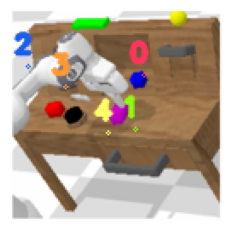

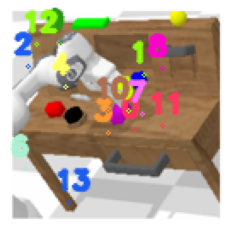

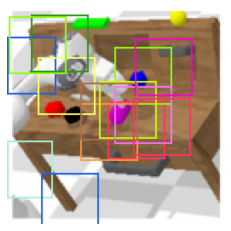

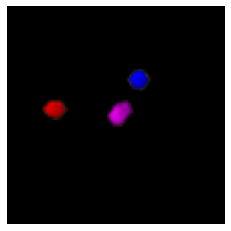

In [3]:
path_to_model_ckpt = './checkpoints/calvin/calvin_dlp_best.pth'
model.load_state_dict(torch.load(path_to_model_ckpt, map_location=device), strict=False)
model.eval()
print("loaded model from checkpoint")

path_to_images = ['./checkpoints/sample_images/calvin/calvin_scene_A.png',
                          './checkpoints/sample_images/calvin/calvin_scene_B.png',
                          './checkpoints/sample_images/calvin/calvin_scene_C.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D_2.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D_3.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D_4.png']

image_idx = min(image_idx, len(path_to_images) - 1)
path_to_image = path_to_images[image_idx]
im = Image.open(path_to_image)
im = im.convert('RGB')
im = im.resize((image_size, image_size), Image.BICUBIC)
trans = transforms.ToTensor()
data = trans(im)
data = data.unsqueeze(0).to(device)
x = data
logvar_threshold = 13.0

with torch.no_grad():
        deterministic = True


        model_output = model(x, x_prior=x)
        
        '''
        mu_p = model_output['kp_p']
        z_base = model_output['z_base']
        mu_offset = model_output['mu_offset']
        logvar_offset = model_output['logvar_offset']
        rec_x = model_output['rec']
        mu_scale = model_output['mu_scale']
        mu_depth = model_output['mu_depth']
        # object stuff
        dec_objects_original = model_output['dec_objects_original']
        cropped_objects_original = model_output['cropped_objects_original']
        obj_on = model_output['obj_on']
        alpha_masks = model_output['alpha_masks']
        
        ''' 
        mu_p = model_output['kp_p']
        # gmap = model_output['gmap']
        mu = model_output['mu']
        logvar = model_output['logvar']
        rec_x = model_output['rec']
        mu_features = model_output['mu_features']
        logvar_features = model_output['logvar_features']
        # object stuff
        dec_objects_original = model_output['dec_objects_original']
        cropped_objects_original = model_output['cropped_objects_original']
        print(model_output.keys())
        print(mu)
        print(rec_x)
        print(mu_p)
        print(mu_features)
        print(logvar_features)
        '''
        enc_out = model.encode_all(data, return_heatmap=True, deterministic=deterministic)
        mu, logvar, kp_heatmap, mu_features, logvar_features, obj_on, order_weights = enc_out
        '''
        if deterministic:
            z = mu
            z_features = mu_features
        else:
            z = reparameterize(mu, logvar)
            z_features = reparameterize(mu_features, logvar_features)
        # top-k
        logvar_sum = logvar.sum(-1)
        logvar_topk = torch.topk(logvar_sum, k=5, dim=-1, largest=False)
        indices = logvar_topk[1]  # [batch_size, topk]
        batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
        topk_kp = mu[batch_indices, indices]
        # bounding boxes
        mask_threshold = 0.2
        masks = create_masks_fast(mu[:, :-1].detach(), anchor_s=model.anchor_s, feature_dim=x.shape[-1])
        masks = torch.where(masks < mask_threshold, 0.0, 1.0)
        bb_scores = -1 * logvar_sum
        hard_threshold = bb_scores.mean()

        # print(masks[0].shape)
        # print(masks[0])
        # print(x[0].shape)
        # print(bb_scores[0].shape)
        # print(bb_scores[0])
        # img_with_masks_nms = plot_bb_on_image_from_masks_nms(masks[0], x[0], scores=bb_scores[0])
        img_with_masks = plot_bb_on_image_from_masks(masks[0], x[0])
        #img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_masks_nms(masks, x,scores=bb_scores)
N = mu.shape[1]
xmin = 0
xmax = image_size

x = np.linspace(xmin, xmax, N)

mu = mu.clamp(kp_range[0], kp_range[1])
original_mu = mu.clone()
mu = (mu - kp_range[0]) / (kp_range[1] - kp_range[0])
xvals = mu[0, :-1, 1].data.cpu().numpy() * (image_size - 1)
yvals = mu[0, :-1, 0].data.cpu().numpy() * (image_size - 1)
if learned_feature_dim > 0:
    feature_1_vals = mu_features[0, :, -1].data.cpu().numpy()
    # set up a plot for topk

topk_kp = topk_kp.clamp(kp_range[0], kp_range[1])
topk_kp = (topk_kp - kp_range[0]) / (kp_range[1] - kp_range[0])
xvals_topk = topk_kp[0, :, 1].data.cpu().numpy() * (image_size - 1)
yvals_topk = topk_kp[0, :, 0].data.cpu().numpy() * (image_size - 1)


#print(topk_kp)
#print(data.shape)
#img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp, data)
img_with_kp_topk = plot_keypoints_on_image(topk_kp[0], data[0])
plt.imshow(img_with_kp_topk)
plt.axis('off') 
plt.show()

img_with_kp = plot_keypoints_on_image(mu[:, :-1][0].clamp(min=kp_range[0], max=kp_range[1]), data[0])
plt.imshow(img_with_kp)
plt.axis('off') 
plt.show()

'''
img_with_kp_p = plot_keypoints_on_image(mu_p[0], data[0])
plt.imshow(img_with_kp_p)
plt.axis('off') 
plt.show()
'''

plt.imshow(img_with_masks)
plt.axis('off')
plt.show()

dec_objects = model_output['dec_objects']
plt.imshow(dec_objects[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
# dec_objects[:max_imgs, -3:]

show image with kps

In [6]:

def showImgWithKP(img, model):
    model.eval()

    im = img
    im = im.convert('RGB')
    im = im.resize((image_size, image_size), Image.BICUBIC)
    trans = transforms.ToTensor()
    data = trans(im)
    data = data.unsqueeze(0).to(device)

    with torch.no_grad():
            model_output = model(data, x_prior=data)

            mu_p = model_output['kp_p']
            # gmap = model_output['gmap']
            mu = model_output['mu']
            logvar = model_output['logvar']
            rec_x = model_output['rec']
            mu_features = model_output['mu_features']
            logvar_features = model_output['logvar_features']

            #print('kp_p: ', mu_p)
            # print('mu: ', mu)
            # print('mu_features: ', mu_features)
            #print('logvar: ', logvar)
            #print('logvar_features: ', logvar_features)
            #print('rec: ', rec_x)

            # top-k
            logvar_sum = logvar.sum(-1)
            logvar_topk = torch.topk(logvar_sum, k=10, dim=-1, largest=False)
            indices = logvar_topk[1]  # [batch_size, topk]
            batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
            topk_kp = mu[batch_indices, indices]

    # print('mu: ', mu[0])

    topk_kp = mu.clamp(kp_range[0], kp_range[1])
    topk_kp = (topk_kp - kp_range[0]) / (kp_range[1] - kp_range[0])

    # print('topk_kp: ', topk_kp[0])

    img_with_kp_topk = plot_keypoints_on_image(topk_kp[0], data[0])

    dec_objects = model_output['dec_objects']
    dec_objects = dec_objects[0].permute(1, 2, 0).cpu().numpy()

    combined_img = np.hstack((img_with_kp_topk / 255.0, dec_objects))

    plt.imshow(combined_img)
    plt.axis('off') 
    plt.show()

def assosiateKP(img1, img2, model):
    model.eval()

    img1 = img1.convert('RGB')
    img1 = img1.resize((image_size, image_size), Image.BICUBIC)
    trans = transforms.ToTensor()
    data1 = trans(img1)
    data1 = data1.unsqueeze(0).to(device)

    img2 = img2.convert('RGB')
    img2 = img2.resize((image_size, image_size), Image.BICUBIC)
    trans = transforms.ToTensor()
    data2 = trans(img2)
    data2 = data2.unsqueeze(0).to(device)

    with torch.no_grad():
        model_output_1 = model(data1, x_prior=data1)
        model_output_2 = model(data2, x_prior=data2)

        mu_coords_1 = model_output_1['mu']
        mu_coords_2 = model_output_2['mu']
        mu_features_1 = model_output_1['mu_features']
        mu_features_2 = model_output_2['mu_features']
        logvar_1 = model_output_1['logvar']
        logvar_2 = model_output_2['logvar']

       # mu_1 = list(zip(mu_coords_1[0], mu_features_1[0]))
       # mu_2 = list(zip(mu_coords_2[0], mu_features_2[0]))
        mu_1 = list(zip(mu_coords_1[0].cpu().numpy(), mu_features_1[0].cpu().numpy()))
        mu_2 = list(zip(mu_coords_2[0].cpu().numpy(), mu_features_2[0].cpu().numpy()))

        matched_KPs = []
        for kp_1, feature_1 in mu_1:
            best_match = None
            best_sim = float('inf')
            for kp_2, feature_2 in mu_2:
                # Euclidean distance 
                geometric_sim = np.linalg.norm(kp_1 - kp_2)
                # Cosine Similarity
                cos_sim = np.dot(feature_1, feature_2) / ((np.linalg.norm(feature_1)) * (np.linalg.norm(feature_2)))
                semantic_sim = abs(1 - cos_sim)

                total_sim = geometric_sim + semantic_sim

                if total_sim < best_sim:
                    best_sim = total_sim
                    best_match = kp_2

                # print('simulatiry: ', total_sim, ' : ', geometric_sim, ' : ', semantic_sim)
            sim_threshold = 0.2
            if best_sim < sim_threshold:
                matched_KPs.append((kp_1, best_match, best_sim))

        # filter keypoints one-to-one
        matched_KPs.sort(key=lambda x: x[2])
        matched_KPs_filtered = []
        matched_kp_1 = []
        matched_kp_2 = []
        for kp_1, kp_2, sim in matched_KPs:
            if (kp_1[0], kp_1[1]) not in matched_kp_1 and (kp_2[0], kp_2[1]) not in matched_kp_2: 
                matched_KPs_filtered.append((kp_1, kp_2, sim))
                matched_kp_1.append((kp_1[0], kp_1[1]))
                matched_kp_2.append((kp_2[0], kp_2[1]))

        # print(matched_KPs_filtered)


    #topk_kp = topk_kp.clamp(kp_range[0], kp_range[1])
    #topk_kp = (topk_kp - kp_range[0]) / (kp_range[1] - kp_range[0])
    
    matched_kp_tuple = []
    for kp_1, kp_2, sim in matched_KPs_filtered:
        kp_1 = ((kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
        kp_2 = ((kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
        kp_tuple = (kp_1, kp_2)
        matched_kp_tuple.append(kp_tuple)

    #matched_kp_tuple = torch.Tensor(matched_kp_tuple)

    image_matched = plot_matched_keypoints(matched_kp_tuple, data2[0])
    plt.imshow(image_matched)
    plt.axis('off') 
    plt.show()  

    kp_1_list = []
    kp_2_list = []

    for kp_1, kp_2, sim in matched_KPs_filtered:
        kp_1_list.append(kp_1)
        kp_2_list.append(kp_2)

        topk_kp_1 = torch.tensor([kp_1]).clamp(kp_range[0], kp_range[1])
        topk_kp_1 = (topk_kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])
        img_with_kp_topk_1 = plot_keypoints_on_image(topk_kp_1, data1[0])

        topk_kp_2 = torch.tensor([kp_2]).clamp(kp_range[0], kp_range[1])
        topk_kp_2 = (topk_kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])   
        img_with_kp_topk_2 = plot_keypoints_on_image(topk_kp_2, data2[0])

        combined_img = np.hstack((img_with_kp_topk_1,  img_with_kp_topk_2))

        plt.imshow(combined_img)
        plt.axis('off') 
        plt.show()  

### Print keypoints for caption

loaded model from checkpoint


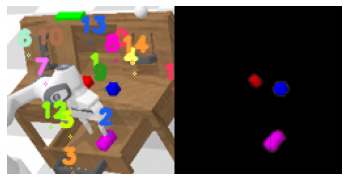

/media/tim/D/ddlp/utils/util_func.py:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)
  kp_1 = torch.tensor([kp[0] for kp in matched_keypoints])


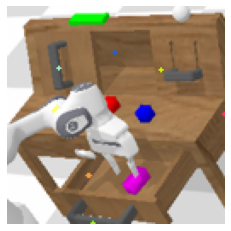

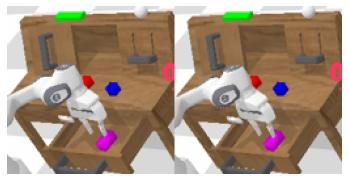

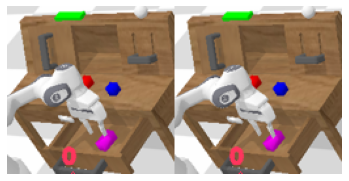

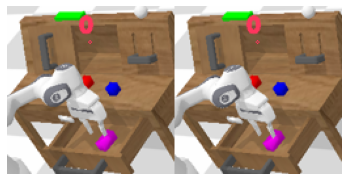

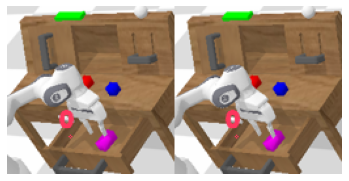

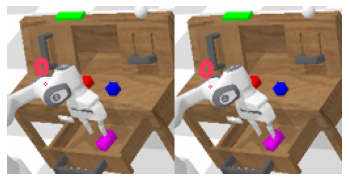

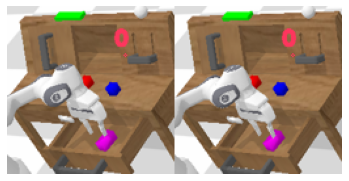

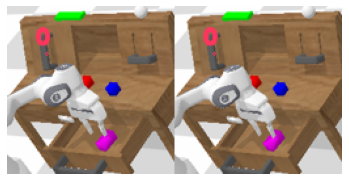

In [7]:
def getIndex(path, ann):
        annotations = np.load('{}/lang_annotations/auto_lang_ann.npy'.format(path), allow_pickle=True).item()
        annotations = list(zip(annotations["info"]["indx"], annotations["language"]["ann"]))
        for annotation in annotations:
                if annotation[1] != ann:
                        continue
                return annotation[0][0]
        return 0


path_to_model_ckpt = './checkpoints/calvin/calvin_dlp_best.pth'
model.load_state_dict(torch.load(path_to_model_ckpt, map_location=device), strict=False)
model.eval()
print("loaded model from checkpoint")

path = '/media/tim/E/datasets/task_D_D/validation'
target_ann = "pick up the pink block from the drawer"
start_index = getIndex(path, target_ann)
        
data_1 = np.load(f"{path}/episode_{start_index + 40:07d}.npz", allow_pickle=True)
img_arr_1 = data_1['rgb_static']
img_1 = Image.fromarray(np.uint8(img_arr_1))
data_2 = np.load(f"{path}/episode_{start_index + 41:07d}.npz", allow_pickle=True)
img_arr_2 = data_2['rgb_static']
img_2 = Image.fromarray(np.uint8(img_arr_2))
        
img_2 = Image.fromarray(np.uint8(img_arr_2))
showImgWithKP(img_1, model)        
assosiateKP(img_1, img_2, model)

## Track keypoints in captioned clip

In [8]:
import cv2


def getIndex(path, ann):
        annotations = np.load('{}/lang_annotations/auto_lang_ann.npy'.format(path), allow_pickle=True).item()
        annotations = list(zip(annotations["info"]["indx"], annotations["language"]["ann"]))
        for annotation in annotations:
                if annotation[1] != ann:
                        continue
                return annotation[0][0]
        return 0

def trackKeyPoints(image_array, model):
    model.eval()
    tracked_keypoints = [] 
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 20 
    frame_size = (128, 128)
    out = cv2.VideoWriter('tracked_keypoints_video.avi', fourcc, fps, frame_size)
    
    print(len(image_array))
    for i in range(len(image_array) - 1):
        
        img1 = Image.fromarray(np.uint8(image_array[i]))
        img1 = img1.convert('RGB')
        img1 = img1.resize((image_size, image_size), Image.BICUBIC)
        trans = transforms.ToTensor()
        data1 = trans(img1)
        data1 = data1.unsqueeze(0).to(device)

        img2 = Image.fromarray(np.uint8(image_array[i + 1]))
        img2 = img2.convert('RGB')
        img2 = img2.resize((image_size, image_size), Image.BICUBIC)
        data2 = trans(img2)
        data2 = data2.unsqueeze(0).to(device)

        with torch.no_grad():
            model_output_1 = model(data1, x_prior=data1)
            model_output_2 = model(data2, x_prior=data2)

            mu_coords_1 = model_output_1['mu']
            mu_coords_2 = model_output_2['mu']
            mu_features_1 = model_output_1['mu_features']
            mu_features_2 = model_output_2['mu_features']

            mu_1 = list(zip(mu_coords_1[0].cpu().numpy(), mu_features_1[0].cpu().numpy()))
            mu_2 = list(zip(mu_coords_2[0].cpu().numpy(), mu_features_2[0].cpu().numpy()))

            matched_KPs = []
            for kp_1, feature_1 in mu_1:
                best_match = None
                best_sim = float('inf')
                for kp_2, feature_2 in mu_2:
                    # Calculate similarity
                    geometric_sim = np.linalg.norm(kp_1 - kp_2)
                    cos_sim = np.dot(feature_1, feature_2) / (np.linalg.norm(feature_1) * np.linalg.norm(feature_2))
                    semantic_sim = abs(1 - cos_sim)
                    total_sim = geometric_sim + semantic_sim
                    if total_sim < best_sim:
                        best_sim = total_sim
                        best_match = kp_2
                sim_threshold = 0.2
                if best_sim < sim_threshold:
                    matched_KPs.append((kp_1, best_match, best_sim))

            # Filter keypoints to ensure one-to-one associations
            matched_KPs.sort(key=lambda x: x[2])
            matched_KPs_filtered = []
            matched_kp_1 = []
            matched_kp_2 = []
            for kp_1, kp_2, sim in matched_KPs:
                if (kp_1[0], kp_1[1]) not in matched_kp_1 and (kp_2[0], kp_2[1]) not in matched_kp_2: 
                    matched_KPs_filtered.append((kp_1, kp_2, sim))
                    matched_kp_1.append((kp_1[0], kp_1[1]))
                    matched_kp_2.append((kp_2[0], kp_2[1]))
            
            tracked_keypoints.append(matched_KPs_filtered)

        matched_kp_tuple = []


        for kp_1, kp_2, sim in matched_KPs_filtered:
            kp_1 = ((kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
            kp_2 = ((kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
            kp_tuple = (kp_1, kp_2)
            matched_kp_tuple.append(kp_tuple)
        image_matched = plot_matched_keypoints(matched_kp_tuple, data2[0])
        plt.imshow(image_matched)
        plt.axis('off') 
        plt.show()  
        out.write(image_matched[:, :, ::-1])

        '''
        for matched_kp in tracked_keypoints:
            matched_kp_tuple = []
            for kp_1, kp_2, sim in matched_kp:
                kp_1 = ((kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
                kp_2 = ((kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
                kp_tuple = (kp_1, kp_2)
                matched_kp_tuple.append(kp_tuple)
            image_matched = plot_matched_keypoints(matched_kp_tuple, data2[0])
            plt.imshow(image_matched)
            plt.axis('off') 
            plt.show()  
        '''
    out.release()
    return tracked_keypoints


def trackKeyPoints_2(image_array, model):
    model.eval()
    tracked_keypoints = [] 
    
    keypoint_colors = {}
    matched_kp_colors = []
    #fourcc = cv2.VideoWriter_fourcc(*'XVID')
    #fps = 20 
    #frame_size = (128, 128)
    #out = cv2.VideoWriter('tracked_keypoints_video_2.avi', fourcc, fps, frame_size)
    
    for i in range(len(image_array) - 1):
        
        img1 = Image.fromarray(np.uint8(image_array[i]))
        img1 = img1.convert('RGB')
        img1 = img1.resize((image_size, image_size), Image.BICUBIC)
        trans = transforms.ToTensor()
        data1 = trans(img1)
        data1 = data1.unsqueeze(0).to(device)

        img2 = Image.fromarray(np.uint8(image_array[i + 1]))
        img2 = img2.convert('RGB')
        img2 = img2.resize((image_size, image_size), Image.BICUBIC)
        data2 = trans(img2)
        data2 = data2.unsqueeze(0).to(device)

        with torch.no_grad():
            model_output_1 = model(data1, x_prior=data1)
            model_output_2 = model(data2, x_prior=data2)

            mu_coords_1 = model_output_1['mu']
            mu_coords_2 = model_output_2['mu']
            mu_features_1 = model_output_1['mu_features']
            mu_features_2 = model_output_2['mu_features']

            '''
            logvar_1 = model_output_1['logvar']
            logvar_sum_1 = logvar_1.sum(-1)
            logvar_topk_1 = torch.topk(logvar_sum_1, k=10, dim=-1, largest=False)
            indices_1 = logvar_topk_1[1]  # [batch_size, topk]
            batch_indices_1 = torch.arange(mu_coords_1.shape[0]).view(-1, 1).to(mu_coords_1.device)
            topk_kp_1 = mu_coords_1[batch_indices_1, indices_1]

            logvar_2 = model_output_2['logvar']
            logvar_sum_2 = logvar_2.sum(-1)
            logvar_topk_2 = torch.topk(logvar_sum_2, k=10, dim=-1, largest=False)
            indices_2 = logvar_topk_2[1]  # [batch_size, topk]
            batch_indices_2 = torch.arange(mu_coords_2.shape[0]).view(-1, 1).to(mu_coords_2.device)
            topk_kp_2 = mu_coords_2[batch_indices_2, indices_2]

            mu_1 = list(zip(topk_kp_1[0].cpu().numpy(), mu_features_1[0].cpu().numpy()))
            mu_2 = list(zip(topk_kp_2[0].cpu().numpy(), mu_features_2[0].cpu().numpy()))
            '''
            mu_1 = list(zip(mu_coords_1[0].cpu().numpy(), mu_features_1[0].cpu().numpy()))
            mu_2 = list(zip(mu_coords_2[0].cpu().numpy(), mu_features_2[0].cpu().numpy()))


            matched_KPs = []
            for kp_1, feature_1 in mu_1:
                best_match = None
                best_sim = float('inf')
                for kp_2, feature_2 in mu_2:
                    # Calculate similarity
                    geometric_sim = np.linalg.norm(kp_1 - kp_2)
                    cos_sim = np.dot(feature_1, feature_2) / (np.linalg.norm(feature_1) * np.linalg.norm(feature_2))
                    semantic_sim = abs(1 - cos_sim)
                    total_sim = geometric_sim + semantic_sim
                    if total_sim < best_sim:
                        best_sim = total_sim
                        best_match = kp_2
                sim_threshold = 0.2
                if best_sim < sim_threshold:
                    matched_KPs.append((kp_1, best_match, best_sim))

            # Filter keypoints to ensure one-to-one associations
            matched_KPs.sort(key=lambda x: x[2])
            matched_KPs_filtered = []
            matched_kp_1 = []
            matched_kp_2 = []
            for kp_1, kp_2, sim in matched_KPs:
                if (kp_1[0], kp_1[1]) not in matched_kp_1 and (kp_2[0], kp_2[1]) not in matched_kp_2: 
                    matched_KPs_filtered.append((kp_1, kp_2, sim))
                    matched_kp_1.append((kp_1[0], kp_1[1]))
                    matched_kp_2.append((kp_2[0], kp_2[1]))
            

        matched_kp_tuple = []
        for kp_1, kp_2, sim in matched_KPs_filtered:
            kp_1 = ((kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)
            kp_2 = ((kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])).clip(0, 1)

            prev_kp = tuple(kp_1)
            next_kp = tuple(kp_2)
            if prev_kp in keypoint_colors:
                color = keypoint_colors[prev_kp]
                keypoint_colors[next_kp] = color
            else:
                color = tuple(np.random.randint(0, 256, size=3))
                keypoint_colors[next_kp] = color

            kp_match_color = {'kp_1' : kp_1, 
                              'kp_2' : kp_2,
                              'color' : color}
            matched_kp_tuple.append(kp_match_color)


        tracked_keypoints.append({'kps' : matched_kp_tuple, 
                                  'img' : data2[0]})

    return tracked_keypoints

In [9]:
path_to_model_ckpt = './checkpoints/calvin/calvin_dlp_best.pth'
model.load_state_dict(torch.load(path_to_model_ckpt, map_location=device), strict=False)
model.eval()
print("loaded model from checkpoint")

path = '/media/tim/E/datasets/task_D_D/validation'
target_ann = "open the drawer"
start_index = getIndex(path, target_ann)
print(start_index)
image_array = []       
for i in range(0, 200):
    data = np.load(f"{path}/episode_{start_index + i:07d}.npz", allow_pickle=True)
    img = data['rgb_static']   
    image_array.append(img)

# trackedPoints = trackKeyPoints(image_array, model)
# print(trackedPoints[0])


tracked_points = trackKeyPoints_2(image_array, model)
# print(tracked_points)

video_img_array = create_tracked_kp_video(tracked_points)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 20 
frame_size = (128, 128)
out = cv2.VideoWriter('tracked_keypoints_video_7.avi', fourcc, fps, frame_size)
for img in video_img_array:
  #  plt.imshow(img)
  #  plt.axis('off') 
  #  plt.show()  
    out.write(img[:, :, ::-1])
out.release()    
    

loaded model from checkpoint
52752
